In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody
from cubic_spline import *

In [2]:
mesh, softbody = data.get_xpbd_grape()

torch.Size([600, 3])
torch.Size([1200, 3])


In [3]:
control_point = 31

In [4]:
norm_vec = np.array([0, 1, 0])
d = 0.005 *np.sqrt(2)/2
seg_plane = pv.Plane(center=(d,d,0), direction=norm_vec, i_size=0.02, j_size=0.01, i_resolution=10, j_resolution=10)

In [5]:
boundary_mask = mesh.points[:cfg.n_surf].copy()

In [6]:
boundary_mask = ((norm_vec @ boundary_mask.T) - 0.005 *np.sqrt(2)/2) < 0

In [7]:
cfg.n_surf - np.sum(boundary_mask)

173

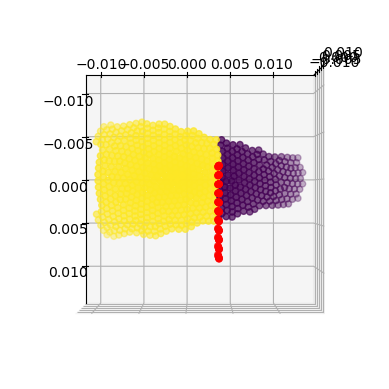

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c=boundary_mask, marker='o')
ax.scatter(seg_plane.points[:, 0], seg_plane.points[:, 1], seg_plane.points[:, 2], c='r')
utils.axisEqual3D(ax)
ax.view_init(elev=90, azim=0)
plt.show()

In [9]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    # V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0
    V_boundary_stiffness_threshold = V_boundary_stiffness_threshold * torch.sigmoid(V_boundary_stiffness_threshold - 1e-3)


    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [10]:
target_boundary_stiffness = boundary_mask * 0.1
target_boundary_stiffness = torch.from_numpy(target_boundary_stiffness).to(cfg.device)

In [11]:
target_list = target_boundary_stiffness < 1e-2

In [12]:
softbody.fix_point(0, control_point)
V_origin = softbody.V.clone()
Velocity_origin = softbody.V_velocity.clone()
mesh_origin = mesh.copy()

In [13]:
# Hardcoded control trajectory
cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

In [14]:
def loss_fn(target, predict, energy, alpha=7e3, gamma = 1.0):
    return torch.norm(target - predict) + energy * alpha * gamma

In [15]:
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.000224, 0.010794, -0.001233]])
start_point = torch.from_numpy(start_point).to(cfg.device)
# spline_control = np.array([ [0.000224, 0.010794, 0.003],
#                             [0.000224, 0.010794, 0.006],
#                             [0.000224, 0.010794, 0.009]])
spline_control = np.array([ [0.000224, 0.008694, 0.001],
                            [0.000224, 0.006594, 0.002]])
spline_control = torch.from_numpy(spline_control).to(cfg.device)
spline_control.requires_grad_(True)

tensor([[0.0002, 0.0087, 0.0010],
        [0.0002, 0.0066, 0.0020]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [16]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [17]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f61be273ee0)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f6197bde980)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [18]:
control = []
loss_list = []
spline_list = []
boundary_energy = []
pre_loss = 100

0
loss: tensor(1.0604, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(7.6536e-07, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(59.9072, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.8905,  -1.7470,   1.9405],
        [  0.3121,  19.4219, -18.4767]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.3179, device='cuda:0') tensor(1., device='cuda:0')
1
loss: tensor(1.0003, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(1.1044e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(74.2101, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[-0.0863, -1.8018,  1.3665],
        [ 0.3038, -0.9860,  0.2127]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.4220, device='cuda:0') tensor(1., device='cuda:0')
2
loss: tensor(0.9557, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(1.3522e-06, device='cuda:0',

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


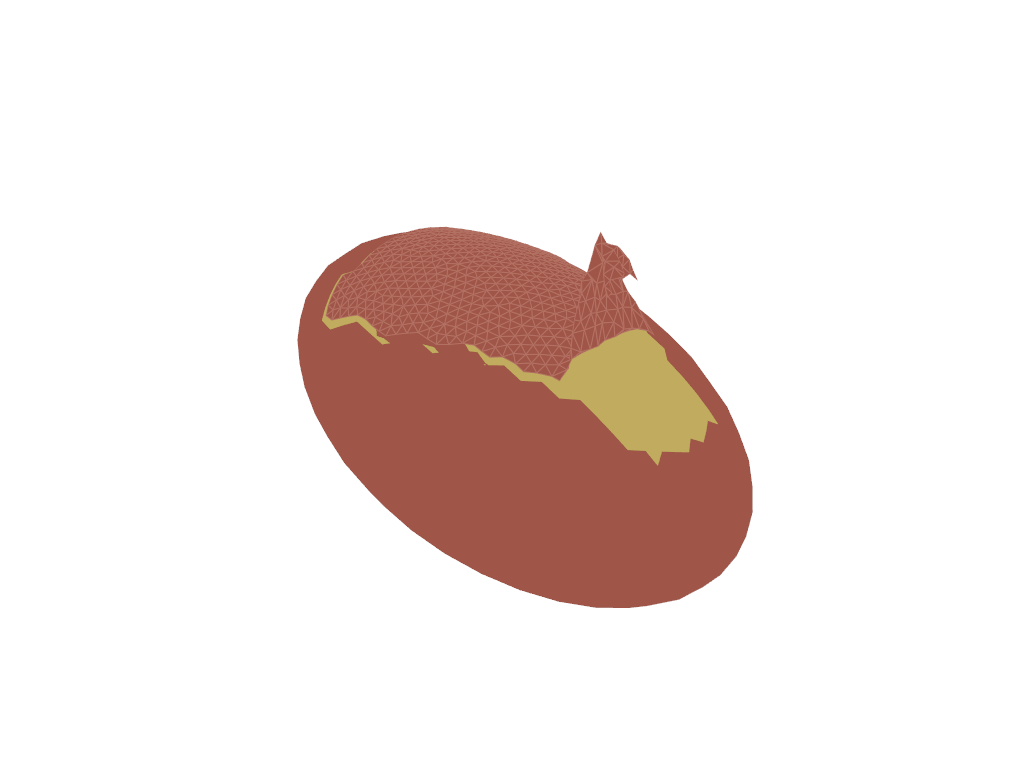

5
loss: tensor(0.8470, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(1.7206e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(102.1292, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -0.3163,  -0.1855,   0.1304],
        [  4.4949,   6.7586, -11.4939]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.5665, device='cuda:0') tensor(1., device='cuda:0')
6
loss: tensor(0.7495, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(1.8129e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(117.3129, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ 0.2014,  0.6192, -0.4242],
        [10.7166,  6.6648, -9.7625]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.6416, device='cuda:0') tensor(1., device='cuda:0')
7
loss: tensor(0.6579, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(1.9185e-06, device='cuda:0

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


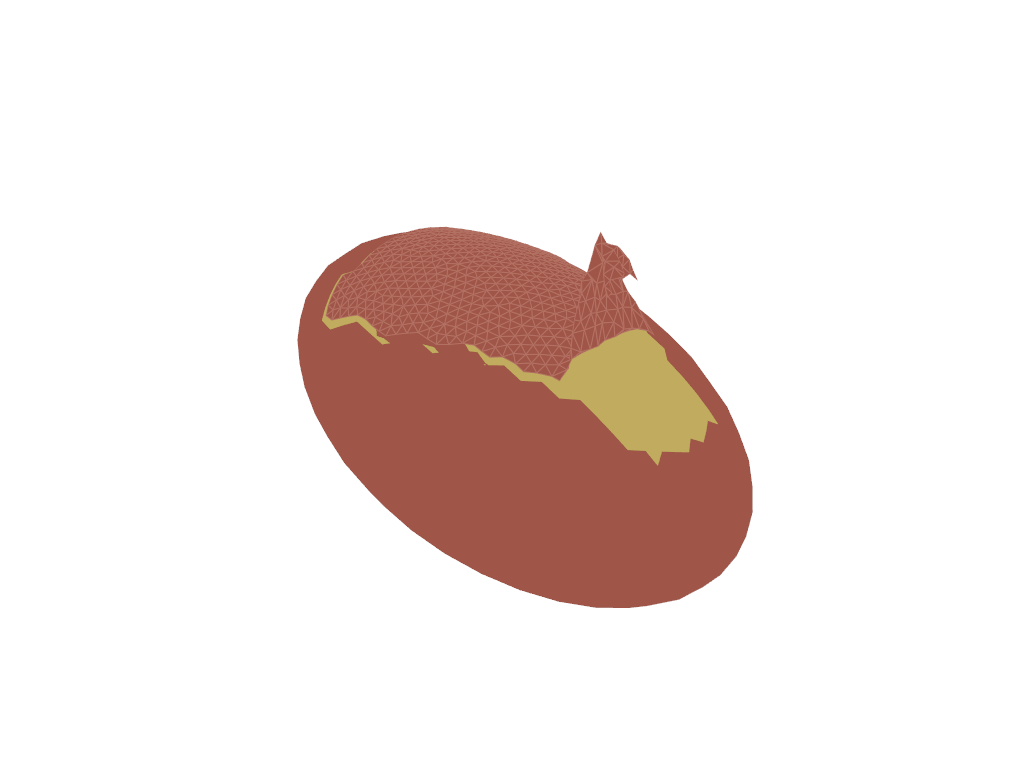

10
loss: tensor(0.4154, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.4373e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(155.8430, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.4494,   1.7460,  -1.7055],
        [ 24.4660,  19.2264, -29.0043]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.8786, device='cuda:0') tensor(1., device='cuda:0')
11
loss: tensor(0.3755, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.5396e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(165.1121, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[-0.4830,  1.1854, -1.1904],
        [-5.9518,  3.6903, -8.7333]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9306, device='cuda:0') tensor(0.9953, device='cuda:0')
12
loss: tensor(0.3442, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8204e-06, device=

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


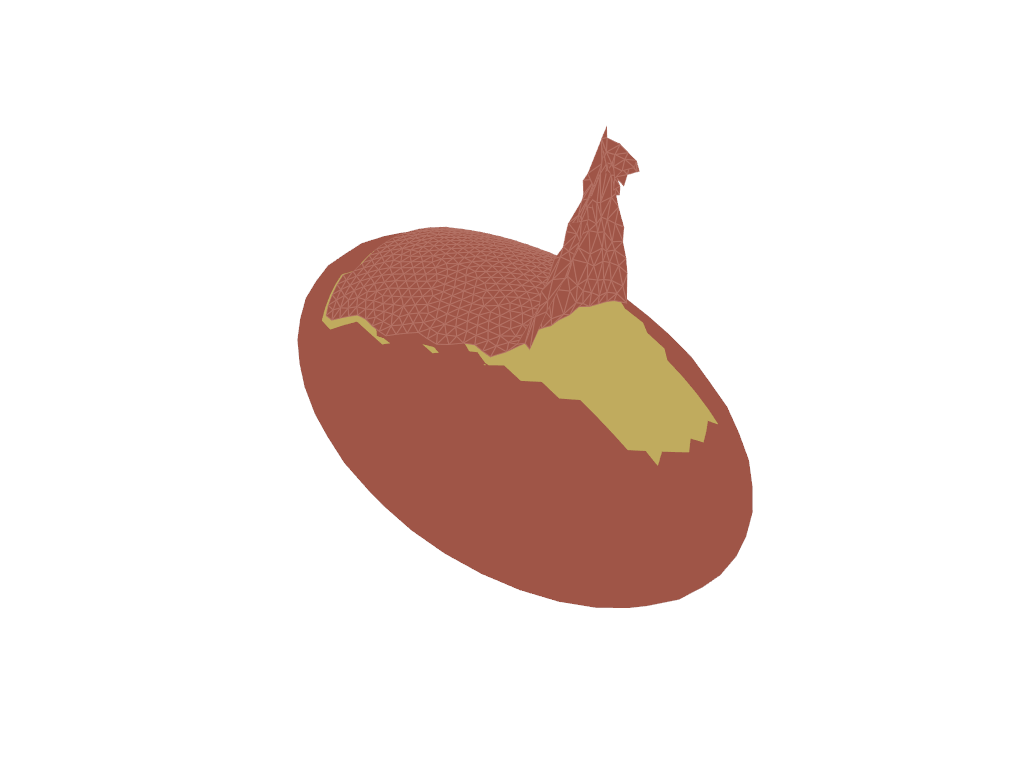

15
loss: tensor(0.4241, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.4557e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(188.2534, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -1.1681,  -0.9107,   1.1579],
        [-18.7151, -12.2837,  19.8765]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9942, device='cuda:0') tensor(0.9672, device='cuda:0')
16
loss: tensor(0.4030, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.4281e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(186.7017, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -1.2358,  -1.3341,   1.5085],
        [-24.4150, -16.5411,  21.8020]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9884, device='cuda:0') tensor(0.9696, device='cuda:0')
17
loss: tensor(0.3400, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.3709e-0

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


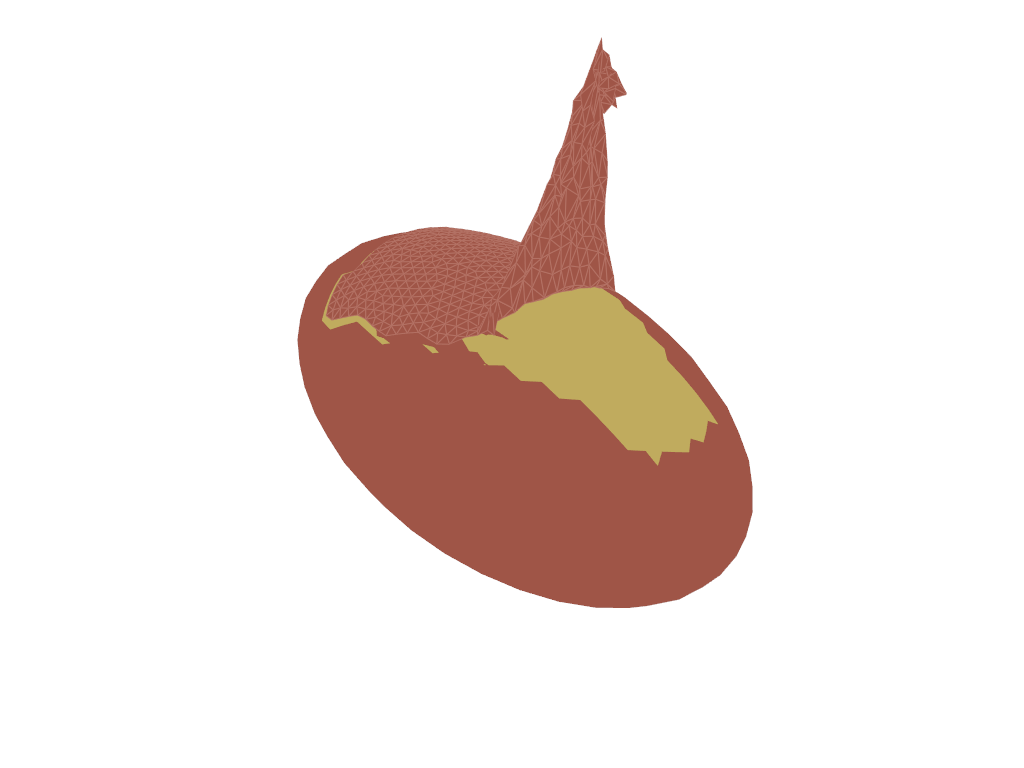

20
loss: tensor(0.2624, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8674e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(172.4121, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.9358,   0.6823,  -0.6226],
        [ -1.3801,  16.3366, -19.2143]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9538, device='cuda:0') tensor(0.9953, device='cuda:0')
21
loss: tensor(0.2466, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8578e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(173.3158, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  1.8144,   0.2729,  -0.6031],
        [ -5.8586,  12.1670, -13.9539]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9769, device='cuda:0') tensor(0.9953, device='cuda:0')
22
loss: tensor(0.2361, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.9429e-0

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


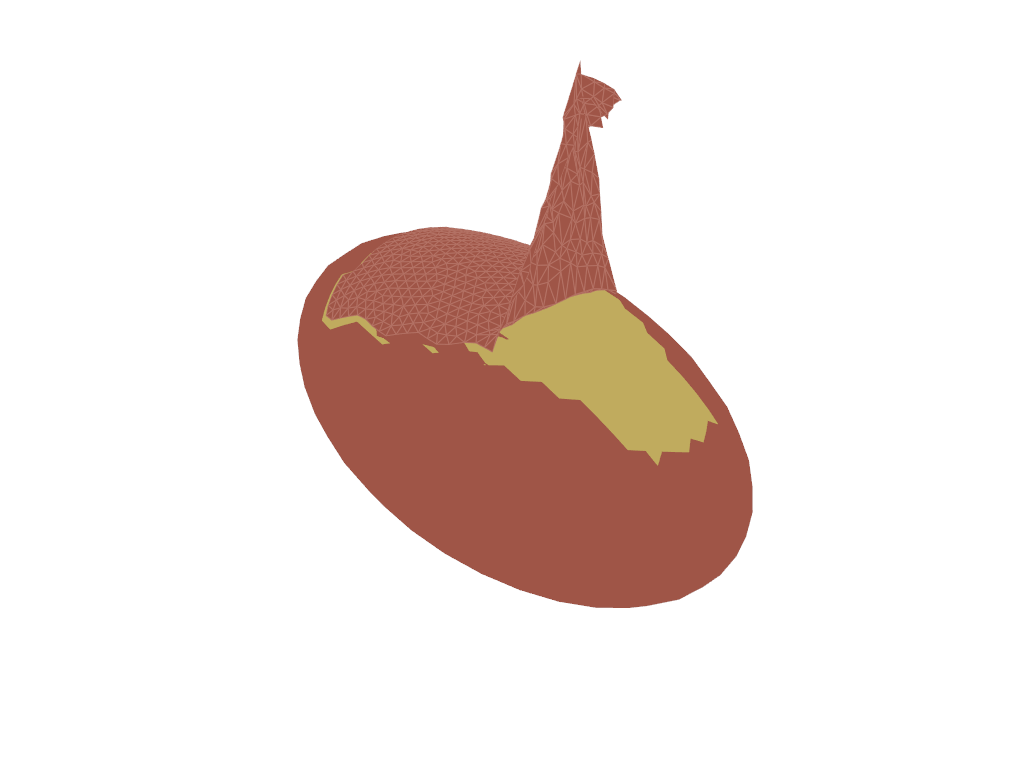

25
loss: tensor(0.1684, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.0873e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(173.3326, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  2.8217,  -1.7994,  -3.5120],
        [  1.0872,  10.2390, -13.2773]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9884, device='cuda:0') tensor(0.9977, device='cuda:0')
26
loss: tensor(0.1652, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.1216e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(173.4161, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ 0.9810, -0.3920,  0.6167],
        [-0.1859,  4.5746, -4.3227]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9884, device='cuda:0') tensor(0.9977, device='cuda:0')
27
loss: tensor(0.1630, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.1686e-06, dev

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


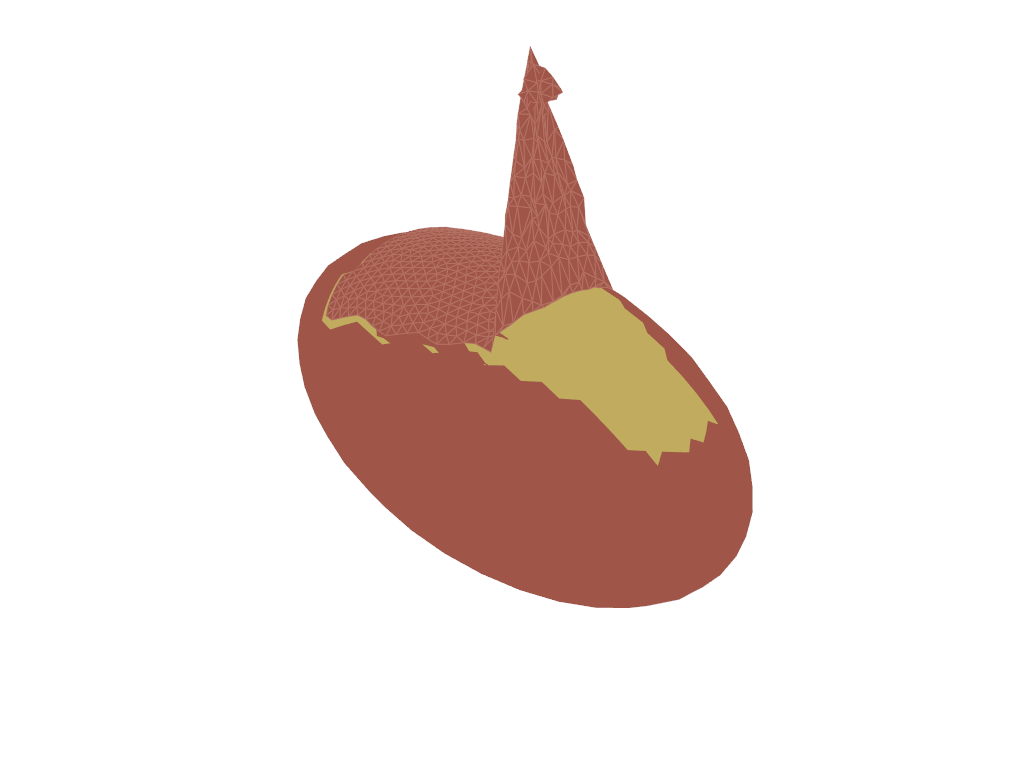

30
loss: tensor(0.1831, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.1143e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(170.9071, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.3958,  -0.5758,   0.9355],
        [ -4.7188,   8.5122, -12.2295]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9827, device='cuda:0') tensor(1., device='cuda:0')
31
loss: tensor(0.2177, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8227e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(169.2645, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.7627,   0.1728,   0.0950],
        [ 11.0709,  25.1965, -38.2469]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9653, device='cuda:0') tensor(1., device='cuda:0')
32
loss: tensor(0.2106, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.7856e-06, devic

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


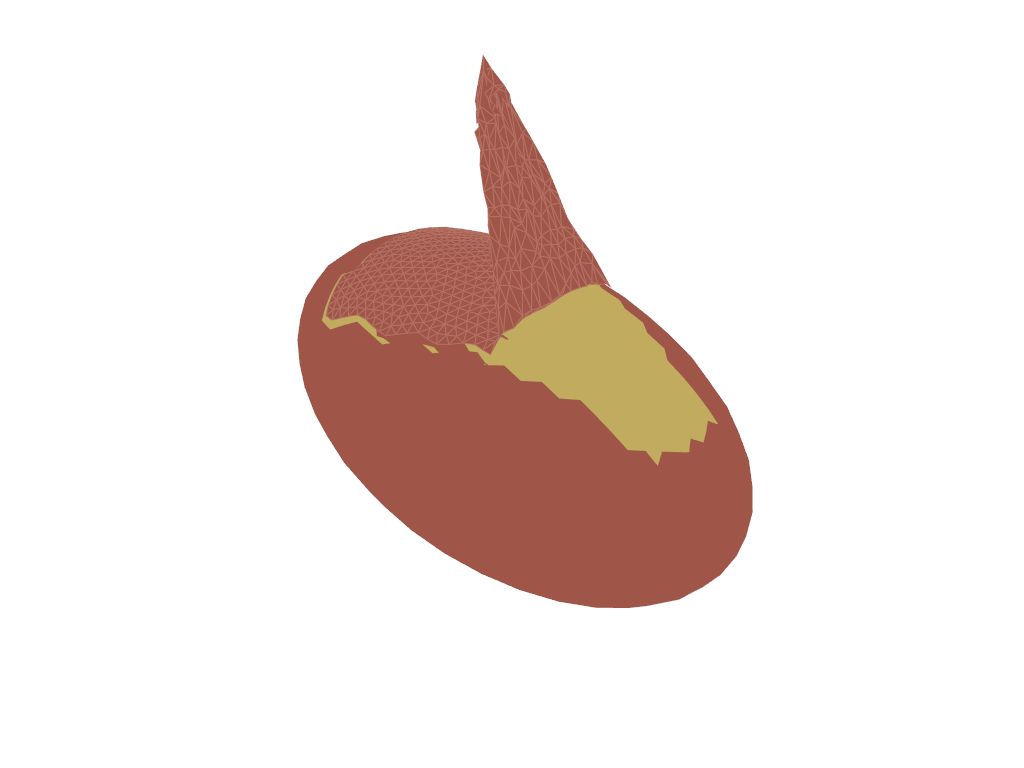

35
loss: tensor(0.1356, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.7697e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(174.8236, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[-0.1531,  1.4916, -0.6554],
        [10.1665, -3.1503,  8.3479]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9884, device='cuda:0') tensor(0.9977, device='cuda:0')
36
loss: tensor(0.2056, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8024e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(170.5643, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ 0.1918,  1.3230, -0.9035],
        [25.5788,  8.3711, -9.3539]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9711, device='cuda:0') tensor(1., device='cuda:0')
37
loss: tensor(0.2342, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.7050e-06, device='cuda:

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


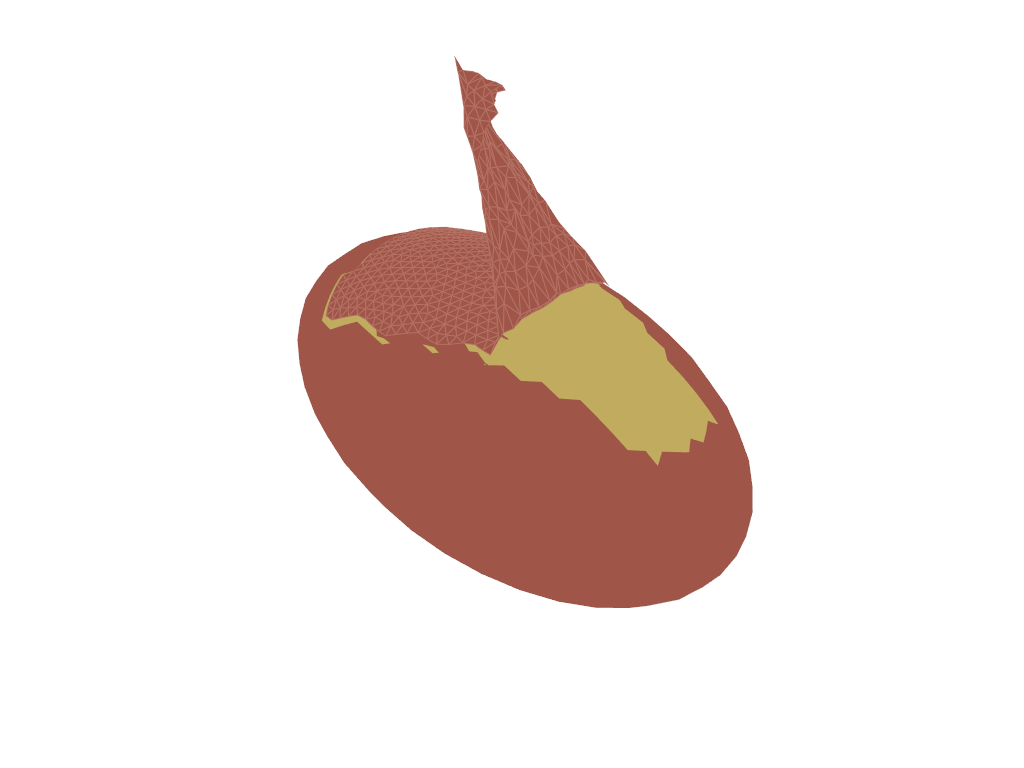

40
loss: tensor(0.1487, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8880e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(173.6751, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -1.3704,   0.3657,  -0.0182],
        [-15.7542,  -0.2403,   1.9071]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9827, device='cuda:0') tensor(0.9977, device='cuda:0')
41
loss: tensor(0.1527, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.0740e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(174.4565, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[-1.4109, -0.4485,  0.5361],
        [-4.9203, -5.6770,  8.2969]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9942, device='cuda:0') tensor(0.9977, device='cuda:0')
42
loss: tensor(0.2244, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.3619e-06, dev

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


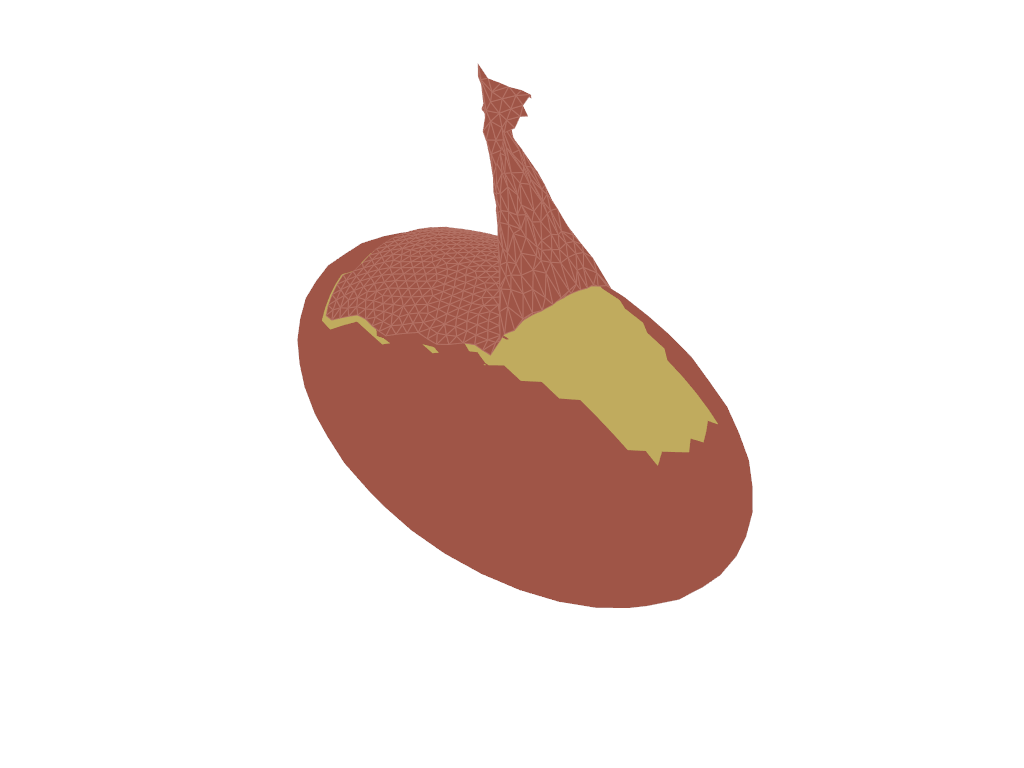

45
loss: tensor(0.2007, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.0851e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(171.3523, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -1.0386,  -1.3906,   1.2902],
        [-15.3404,  -8.2492,  14.1711]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9827, device='cuda:0') tensor(1., device='cuda:0')
46
loss: tensor(0.2157, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(3.0140e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(169.2438, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.1079,   0.2623,  -0.2066],
        [ 17.9079,  33.3203, -41.5455]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9653, device='cuda:0') tensor(1., device='cuda:0')
47
loss: tensor(0.2332, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.9666e-06, devic

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


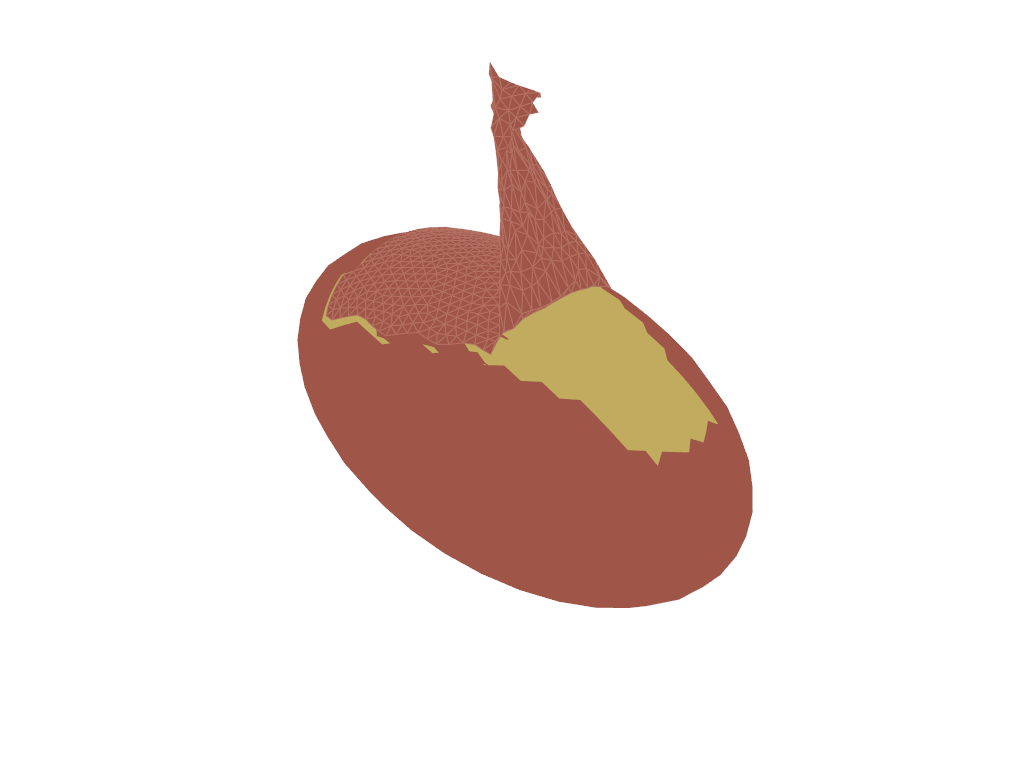

50
loss: tensor(0.1613, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.8541e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(173.8615, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ 0.1288, -0.8665, -2.4007],
        [-7.9263, -5.4371,  6.4109]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9942, device='cuda:0') tensor(0.9977, device='cuda:0')
51
loss: tensor(0.1917, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.9414e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(176.0839, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -0.4948,  -0.5567,   0.7824],
        [-11.3619, -46.1040,  59.3859]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9942, device='cuda:0') tensor(0.9977, device='cuda:0')
52
loss: tensor(0.1994, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.9017e-06, dev

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


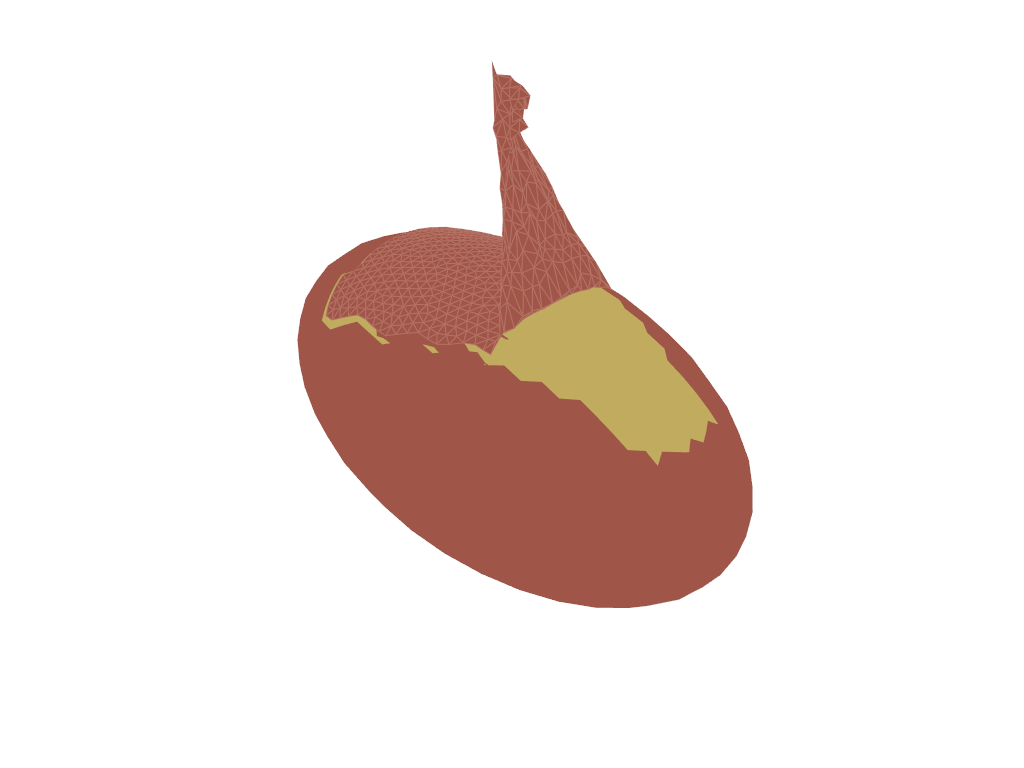

55
loss: tensor(0.1847, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.6371e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(172.1531, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[  0.7012,   1.3463,  -1.6773],
        [  7.9171,  30.4765, -27.8968]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9827, device='cuda:0') tensor(0.9977, device='cuda:0')
56
loss: tensor(0.1717, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.7727e-06, device='cuda:0', grad_fn=<SumBackward0>)
breaked boundary: tensor(172.9178, device='cuda:0', grad_fn=<RsubBackward1>)
current grad tensor([[ -0.0340,   0.6325,  -1.4325],
        [  7.3132,  23.8471, -19.4525]], device='cuda:0', dtype=torch.float64)
peeling arccuracy tensor(0.9827, device='cuda:0') tensor(0.9977, device='cuda:0')
57
loss: tensor(0.1632, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
energy: tensor(2.7612e-0

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


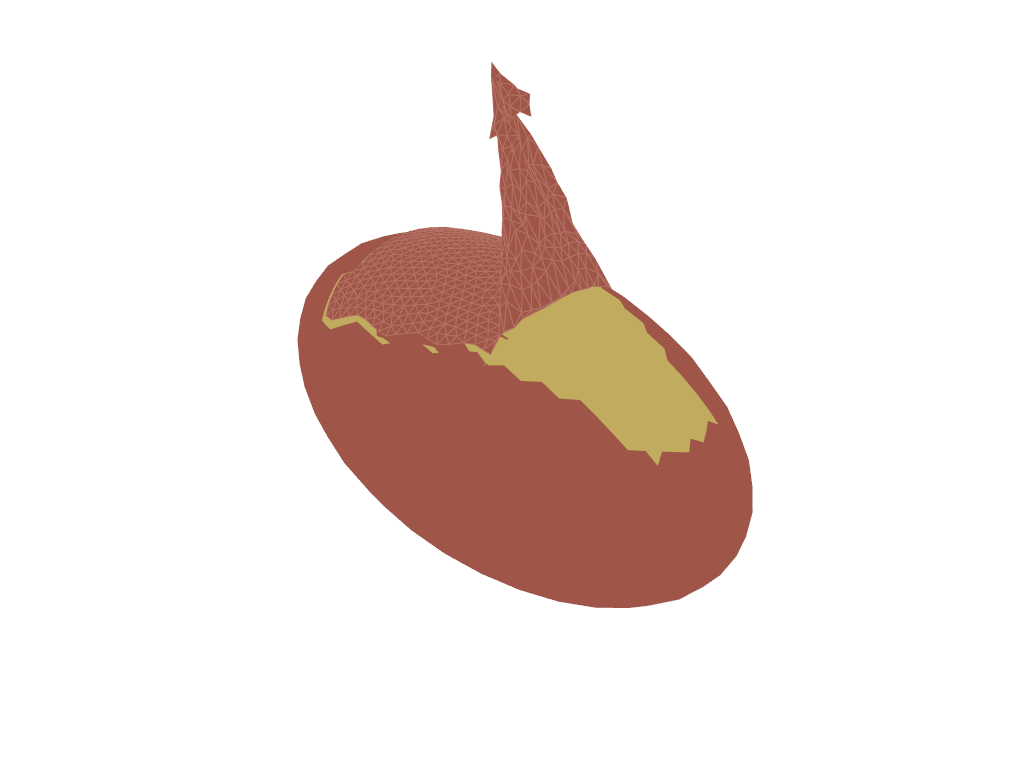

In [19]:
for t in range(60):
    print(t)
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline_x = interp(u, x_con, us)
    spline_y = interp(u, y_con, us)
    spline_z = interp(u, z_con, us)

    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    spline_list.append(spline_trajectory.detach().cpu().numpy())
    # reset for each test
    softbody.V = V_origin.clone()
    softbody.V_velocity = Velocity_origin.clone()

    cloth_dist_stiffness = 1
    V_boundary_stiffness = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
    energy_total = torch.zeros(1).to(cfg.device)
    boundary_energy_matrix = torch.zeros(50, 600).to(cfg.device)
    for i in range(spline_trajectory.shape[0]):
        softbody.V[control_point] = spline_trajectory[i]
        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        boundary_energy_matrix[i] = energy.squeeze()
        V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy))
        # energy_total = energy_total + torch.sum(energy)
    
    n_break_boundary =cfg.n_surf - torch.sum(V_boundary_stiffness[:cfg.n_surf]) * 10
    boundary_max_energy, _ = torch.max(boundary_energy_matrix, 0)
    energy_total = torch.sum(boundary_max_energy)
    # interpolate trajectory
    break_list = V_boundary_stiffness[:cfg.n_surf].detach() < 1e-2
    score1 = torch.sum(break_list.reshape(cfg.n_surf) & target_list) / torch.sum(target_list)
    score2 = torch.sum(torch.logical_not(break_list.reshape(cfg.n_surf) | target_list)) / torch.sum(torch.logical_not(target_list))
    loss = loss_fn(target_boundary_stiffness, V_boundary_stiffness[:cfg.n_surf].reshape(cfg.n_surf), energy_total)
    loss.backward()
    
    loss_list.append(loss.detach().cpu())
    boundary_energy.append((energy_total / n_break_boundary).detach().cpu())
    print('loss:', str(loss))
    # print('energy per break boundary', energy_total / n_break_boundary)
    print('energy:', energy_total)
    print('breaked boundary:', n_break_boundary)
    print('current grad', spline_control.grad)
    print('peeling arccuracy', score1, score2)
    # if score > 0.9:
    #     break
    optimizer.step()
    optimizer.zero_grad()
    
    mesh.points = softbody.V.detach().cpu().numpy()
    if (t + 1) % 5 == 0:
        pl.show(interactive_update=True)

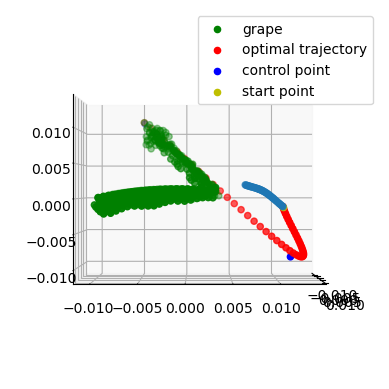

In [20]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='g', marker='o', label='grape')
ax.scatter(spline_trajectory[:, 0].cpu().detach(), spline_trajectory[:, 1].cpu().detach(), spline_trajectory[:, 2].cpu().detach(), c='r', marker='o', label='optimal trajectory')
ax.scatter(spline_control[:, 0].cpu().detach(), spline_control[:, 1].cpu().detach(), spline_control[:, 2].cpu().detach(), c='b', marker='o', label='control point')
ax.scatter(start_point[:, 0].cpu().detach(), start_point[:, 1].cpu().detach(), start_point[:, 2].cpu().detach(), c='y', marker='o', label='start point')
ax.scatter(spline_list[0][:, 0], spline_list[0][:, 1], spline_list[0][:, 2])
utils.axisEqual3D(ax)
ax.view_init(elev=0, azim=0)
ax.legend()
plt.show()

In [21]:
spline_mesh = mesh.copy()

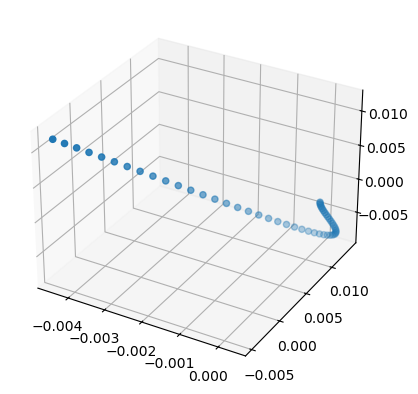

In [22]:
ax = plt.figure().add_subplot(projection='3d')
for i in spline_list[-2:-1]:
    ax.scatter(i[:, 0], i[:, 1], i[:, 2], marker='o')

Text(0, 0.5, 'loss')

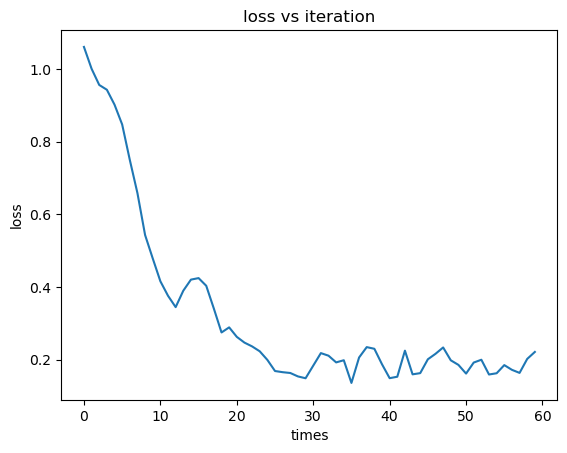

In [23]:
plt.plot(loss_list)
plt.title('loss vs iteration')
plt.xlabel('times')
plt.ylabel('loss')

Text(0, 0.5, 'energy per boundary')

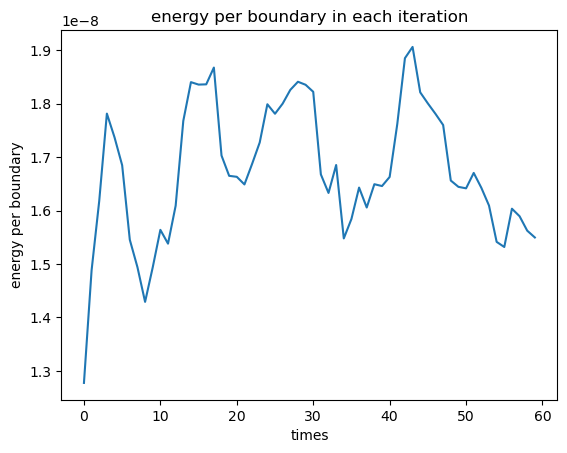

In [24]:
plt.plot(boundary_energy)
plt.title('energy per boundary in each iteration')
plt.xlabel('times')
plt.ylabel('energy per boundary')

In [25]:
spline_control

tensor([[-0.0010,  0.0117, -0.0087],
        [-0.0046, -0.0047,  0.0113]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [26]:
spline_line = spline_trajectory.detach().cpu().numpy()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


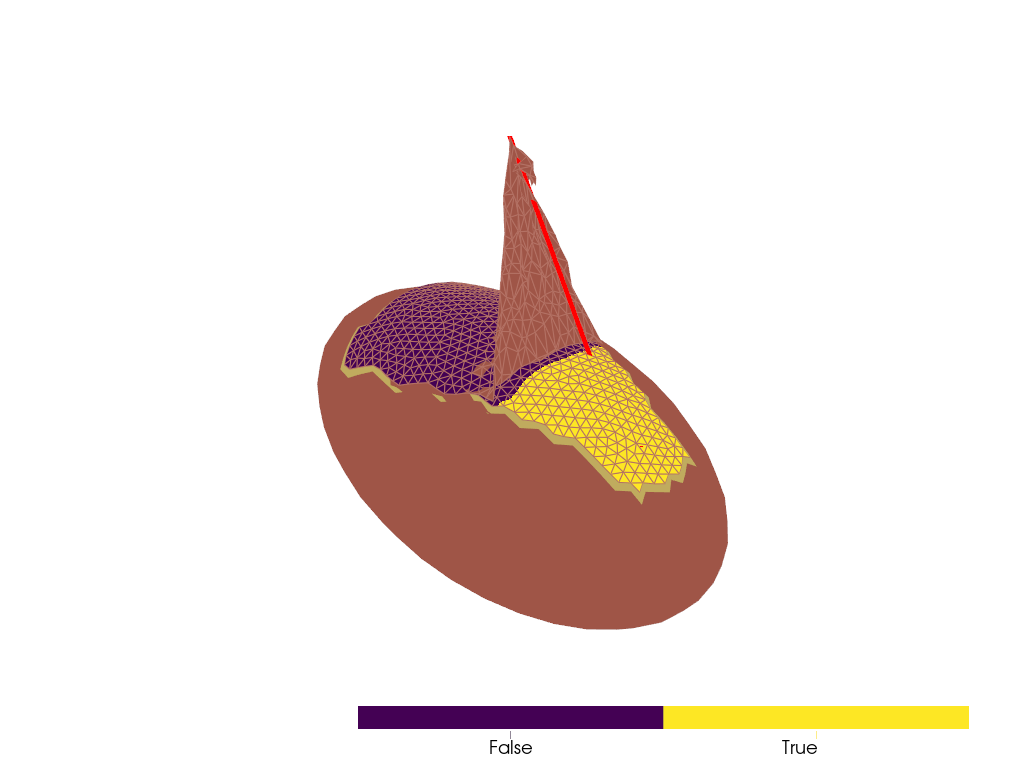

In [27]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(spline_mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
pl.add_mesh(mesh_origin, scalars=target_list.cpu(), show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# control line
pl.add_lines(spline_line, color='r', connected=True)
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')
pl.show()

In [28]:
mesh, softbody = data.get_xpbd_grape()
softbody.fix_point(0, control_point)
mesh_origin = mesh.copy()

torch.Size([600, 3])
torch.Size([1200, 3])


In [29]:
pv.set_plot_theme('document')
pl = pv.Plotter()
# skin being peeled
pl.add_mesh(mesh_origin, scalars=target_list.cpu(), show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# control line
# pl.add_lines(spline_line, color='r', connected=True)
# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f6181ebd6c0)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f6181ebdf00)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [30]:
x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
us = torch.linspace(0, 1, 50).to(cfg.device)
u = torch.linspace(0, 1, 2).to(cfg.device)
spline_x = interp(u, x_con, us)
spline_y = interp(u, y_con, us)
spline_z = interp(u, z_con, us)

spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
# reset for each test
softbody.V = V_origin.clone()
softbody.V_velocity = Velocity_origin.clone()

cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness
energy_list = []
pl.open_gif('boundary_energy_based_optimize.gif')
for i in range(spline_trajectory.shape[0]):
    softbody.V[control_point] = spline_trajectory[i]
    step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=None,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=cfg.use_shape_matching,
                    use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    ref_V_boundary_stiffness = V_boundary_stiffness[:cfg.n_surf].detach().clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness[:cfg.n_surf] = ref_V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy))
    mesh.points = softbody.V.detach().cpu().numpy()
    energy_list.append(energy.detach().cpu().numpy().reshape(cfg.n_surf))
    # pl.update()
    pl.write_frame()
pl.close()

In [31]:
energy_list = np.array(energy_list)

In [32]:
energy_per_iter = np.sum(energy_list, axis=1)

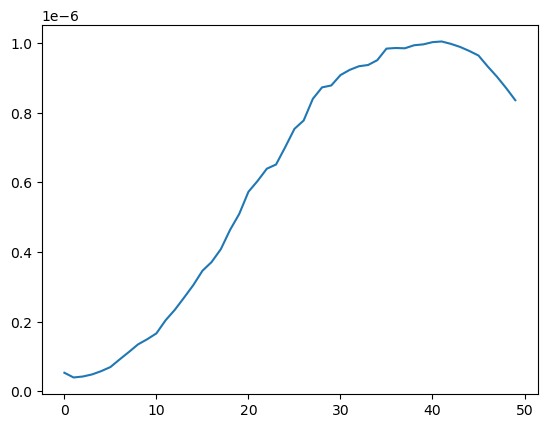

In [33]:
plt.plot(energy_per_iter)

In [34]:
np.sum(energy_per_iter)

3.046165e-05

In [35]:
energy_total

tensor(2.7268e-06, device='cuda:0', grad_fn=<SumBackward0>)